## GENERAL SETUP

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gallifrey.planets import PlanetModel
from gallifrey.utilities.dataframe import rename_labels
from gallifrey.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
    contour_plot,
)

## PLOT SETUP

In [4]:
set_plot_defaults()
figure_directory = "Planet_model"

## REDUCING DIMENSIONALITY

In [5]:
num_samples = int(1e5)

num_embryos = 50
host_star_mass = 1

planet_model = PlanetModel(num_embryos)
population_id = planet_model.get_population_id(num_embryos, host_star_mass)

categories = [
    category
    for category in planet_model.categories
    if category not in ["Dwarf", "D-Burner"]
]
included_variables = ("log_initial_mass", "[Fe/H]")

### Creating Sample of included Monte Carlo Variables

In [6]:
bounds = {
    variable: planet_model.get_systems(population_id).bounds[variable]
    for variable in included_variables
}
samples = np.column_stack(
    [np.random.uniform(bound[0], bound[1], num_samples) for bound in bounds.values()]
)
samples = pd.DataFrame(samples, columns=bounds.keys())

### Compare behaviour of full and reduced model

In [7]:
prediction_parameter_dict = {
    "categories": categories,
    "host_star_mass": host_star_mass,
    "variables": samples,
    "return_full": False,
}

full_model = planet_model.prediction(**prediction_parameter_dict)
reduced_model = planet_model.prediction(
    **prediction_parameter_dict, included_variables=included_variables
)
model_difference = full_model - reduced_model

model_difference.describe()

,Earth,Super-Earth,Neptunian,Sub-Giant,Giant
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.227568,0.356596,0.003103,0.006944,-0.039848
std,0.970956,0.892762,0.253467,0.088510,0.168442
min,-4.033333,-3.566667,-1.366667,-0.633333,-1.100000
25%,-0.333333,-0.133333,-0.033333,0.000000,-0.033333
50%,0.166667,0.366667,0.000000,0.000000,0.000000
75%,0.766667,0.900000,0.100000,0.033333,0.000000
max,4.766667,4.266667,1.200000,0.533333,0.666667


## HYPERPARAMETER TUNING

In [8]:
# recreate original sample
original_variables = planet_model.get_systems(population_id).variables
original_sample = planet_model.prediction(
    categories,
    host_star_mass,
    variables=original_variables,
    return_full=True,
    neighbors=1,
)

In [9]:
# checking for optimal number of neighbors using k-fold cross-validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

X = original_sample[list(included_variables)]
X_scaled = StandardScaler().fit_transform(X)
y = original_sample[categories]

# perform hyperparameter optimization using cross validation on data
hyperparameter_grid = {"n_neighbors": range(1, 101), "weights": ["uniform", "distance"]}

hp_search = GridSearchCV(
    KNeighborsRegressor(), hyperparameter_grid, cv=10
)  # Using 10-fold CV
hp_search.fit(X_scaled, y)

print(f"Best parameter: {hp_search.best_params_}")

Best parameter: {'n_neighbors': 30, 'weights': 'uniform'}


## MODEL BEHAVIOUR

In [10]:
num_bins = 100
included_variables = ("[Fe/H]", "log_initial_mass")

### Grid of Monte Carlo Variables

In [11]:
variable_grid = planet_model.get_systems(population_id).variable_grid(
    num_bins,
    included_variables=included_variables,
    as_dataframe=True,
)

grid_results = planet_model.prediction(
    categories,
    host_star_mass,
    variables=variable_grid,
    included_variables=included_variables,
    return_full=True,
)

grid_results = planet_model.calculate_solid_mass(grid_results, return_full=True)

grid_results, variable_labels = rename_labels(grid_results)

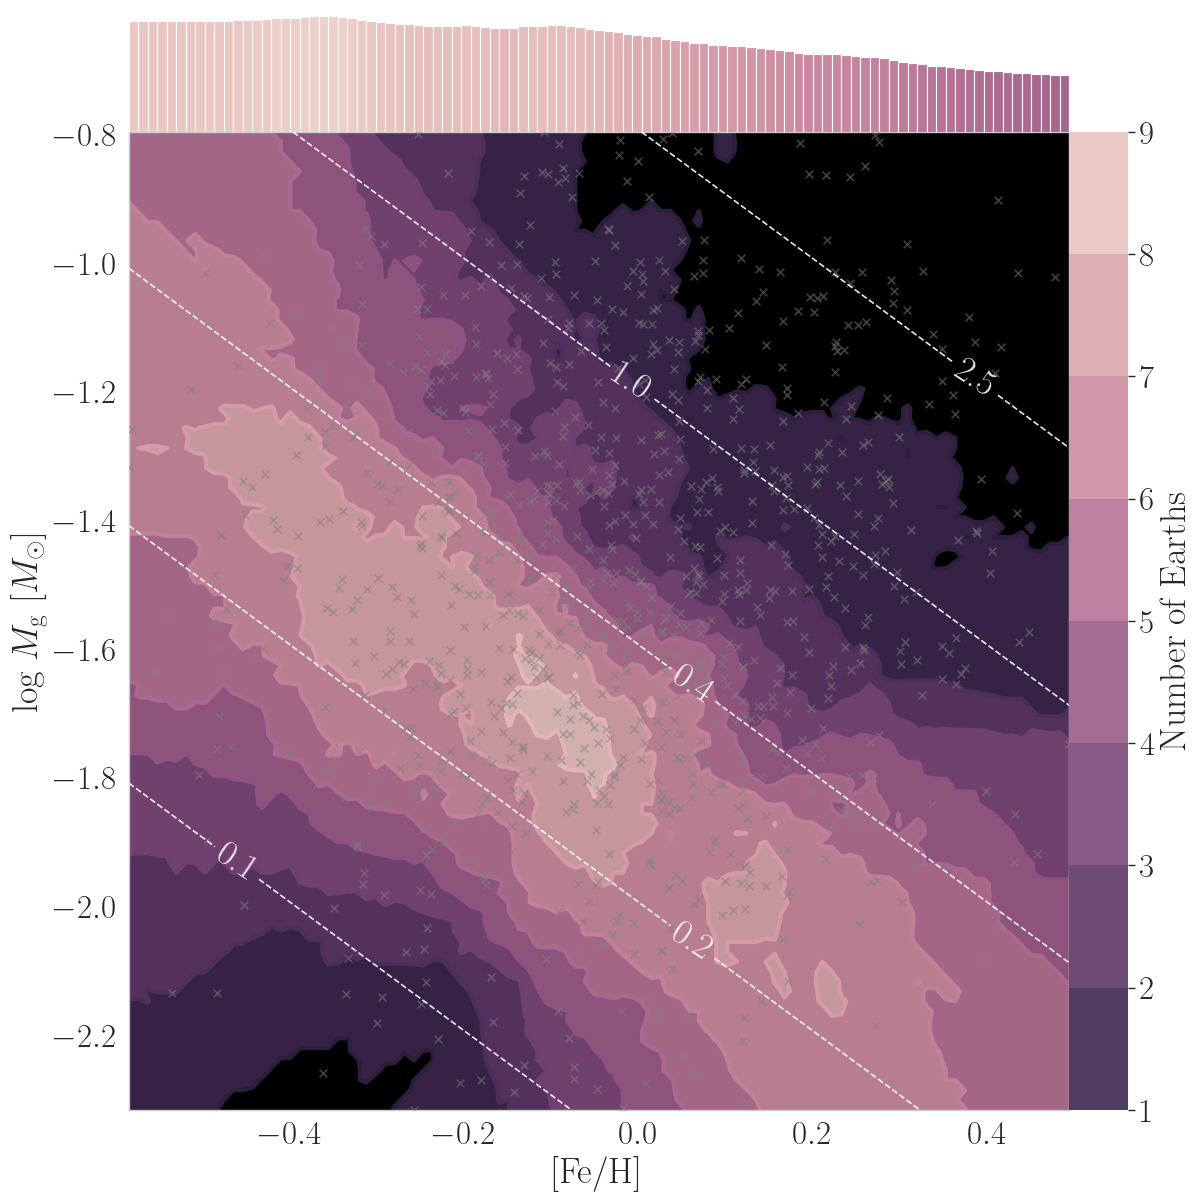

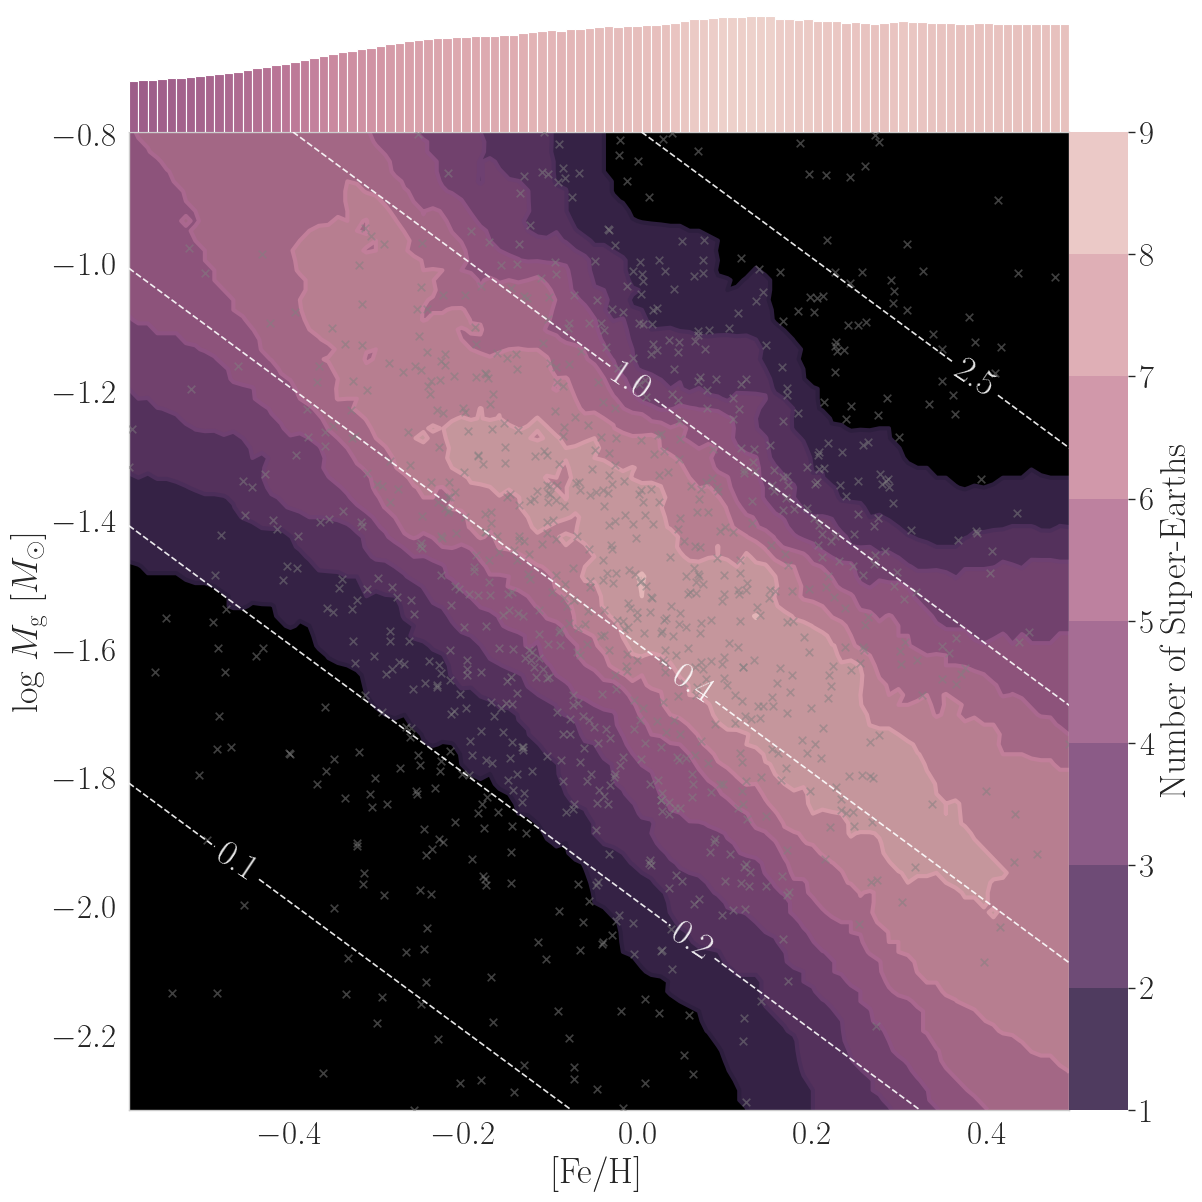

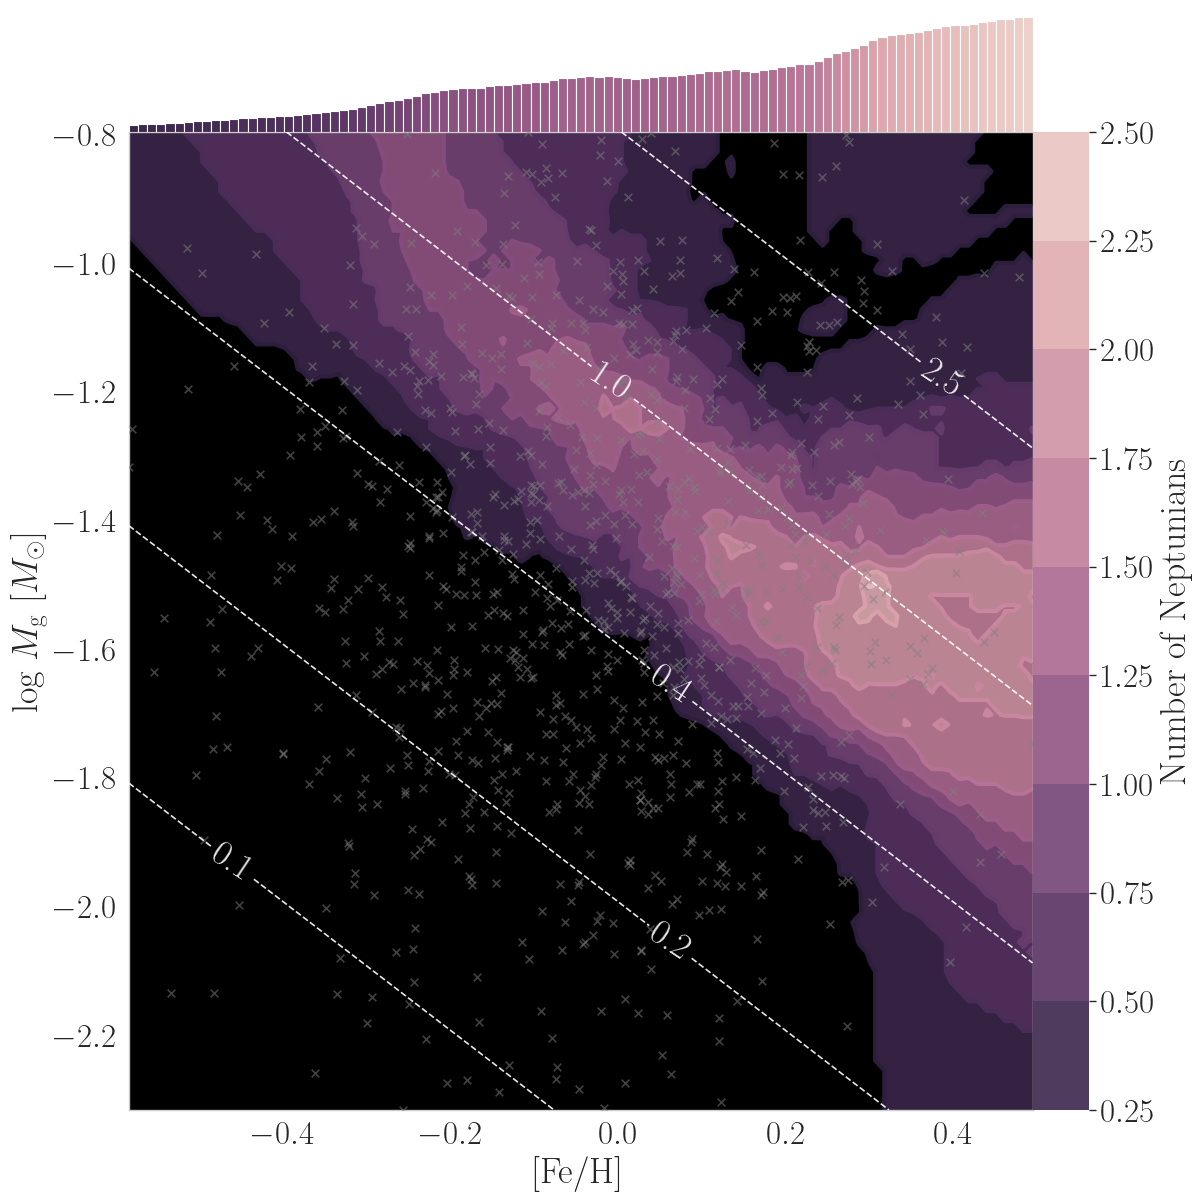

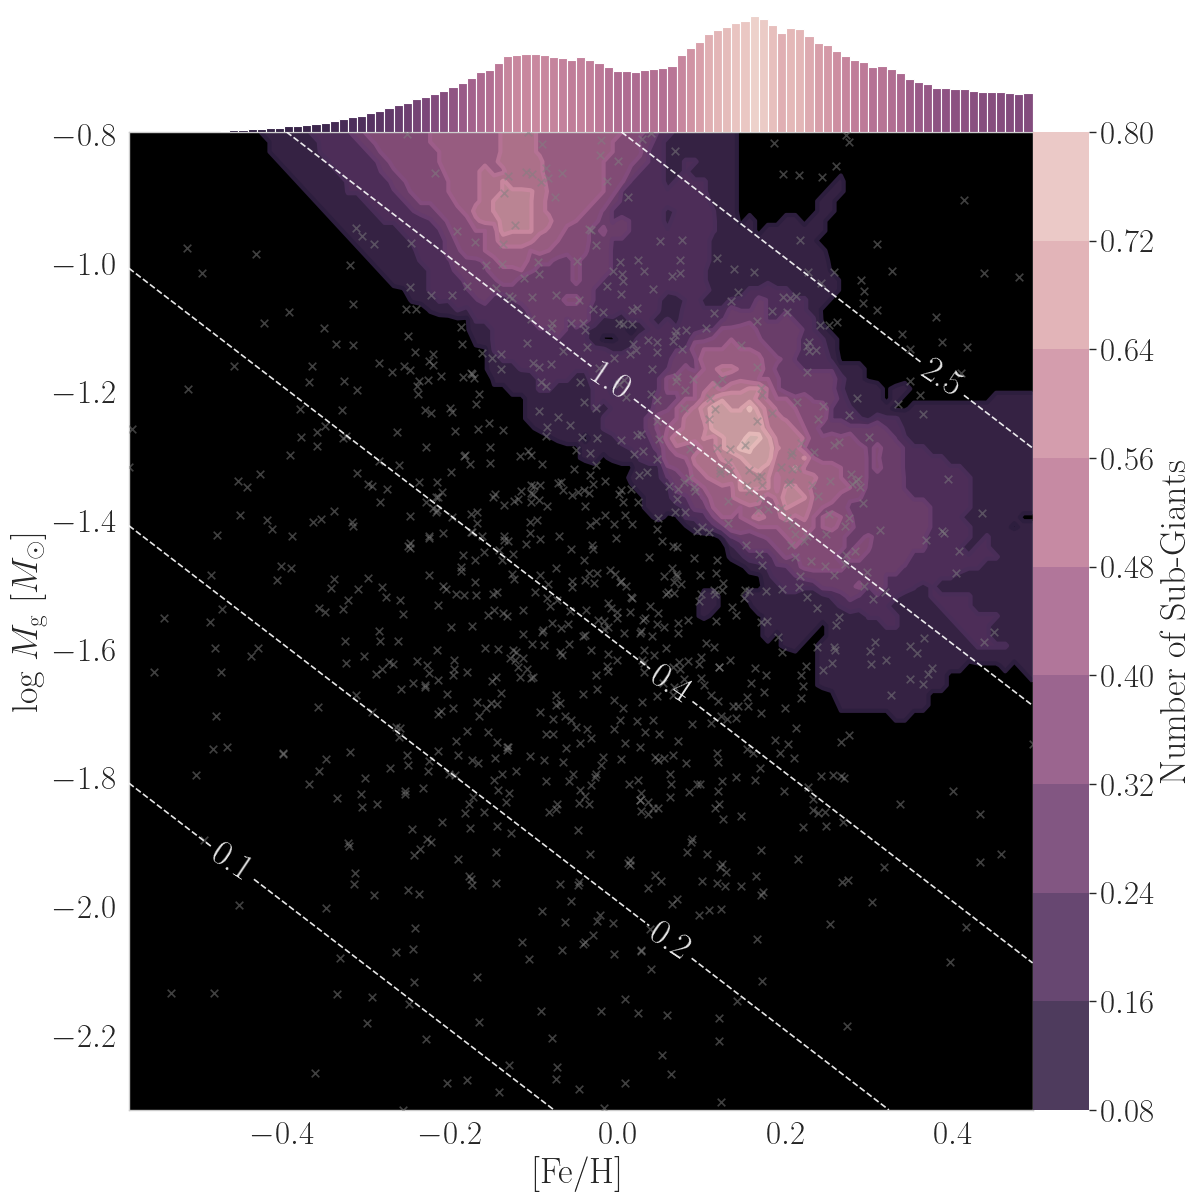

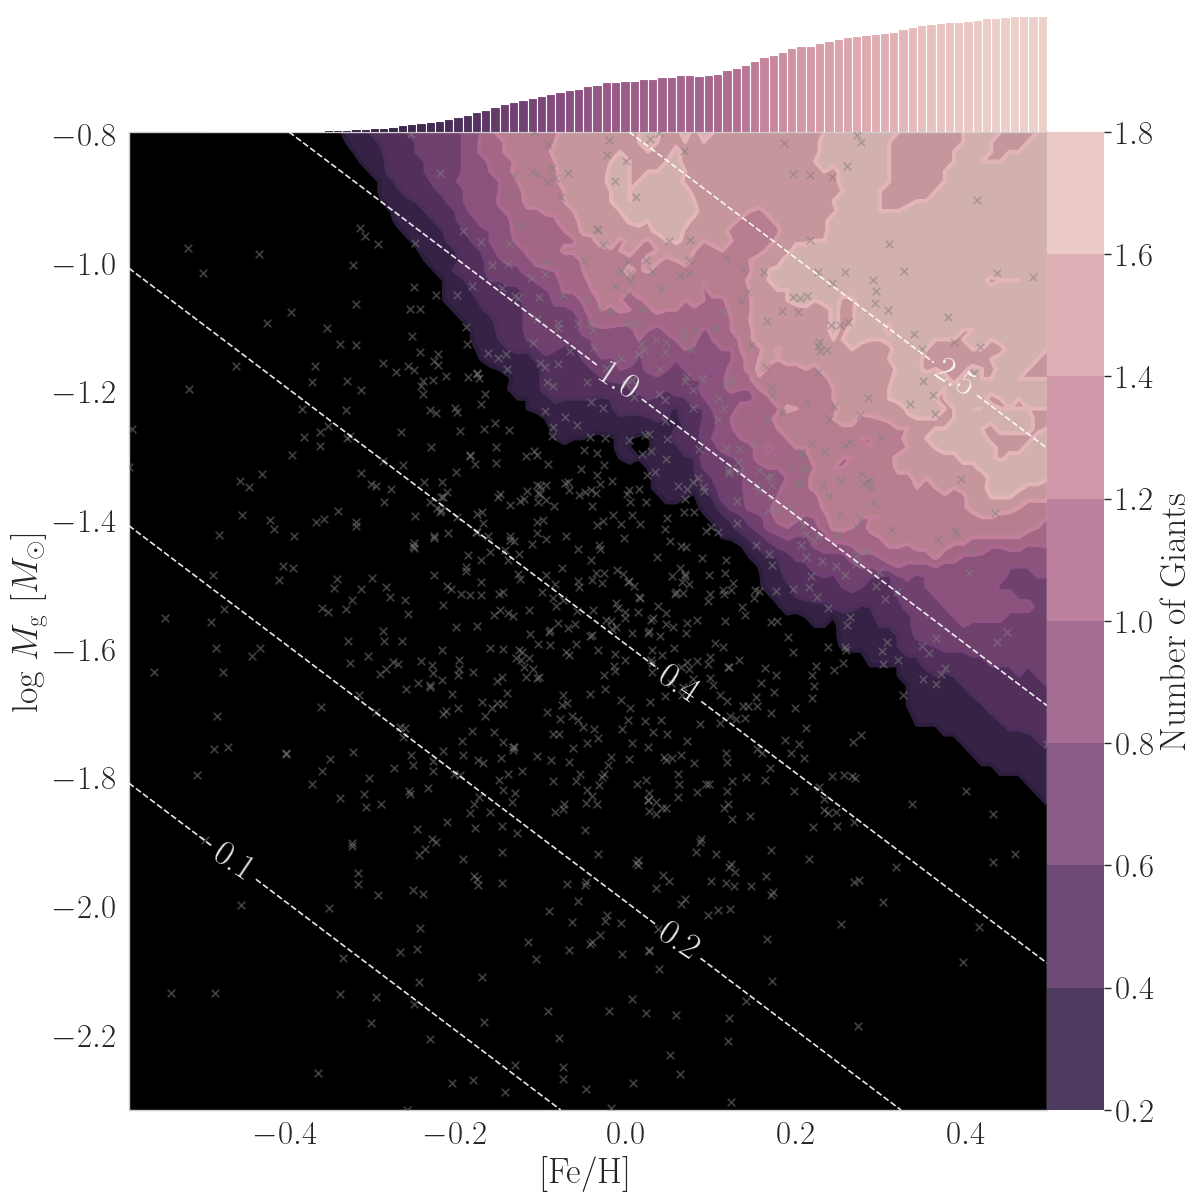

In [25]:
for category in categories:
    contourplot, axes = contour_plot(
        data=grid_results,
        x=variable_labels[0],
        y=variable_labels[1],
        hue=category,
        reshaping_bins=num_bins,
        additional_contours=variable_labels[2],
        cmap=get_palette(reverse=True, as_cmap=True),
        colorbar_label=f"Number of {category}s",
        square_aspect_ratio=True,
        outline=True,
        prune_lowest=True,
        contour_label_fmt=lambda log_solid_mass: "%1.1f" % (10**log_solid_mass),
        kws={"alpha": 0.9},
        okws={"linewidths": 3},
        ackws={
            "levels": [-1.2, -0.8, -0.4, 0, 0.4],
            "colors": "white",
            "linestyles": "dashed",
            "zorder": 10,
            "alpha": 0.9,
        },
    )
    # add locations of original sample
    axes[0].scatter(
        x=original_sample["[Fe/H]"],
        y=original_sample["log_initial_mass"],
        color="grey",
        marker="x",
        alpha=0.5,
        s=30,
        zorder=9,
    )

    # save figure
    FigureProcessor(contourplot.figure).save(
        f"contourplot_{category}.pdf", sub_directory=figure_directory
    )